In [1]:
# This notebook fits an initial model at alpha0
# then it refits alternative models for different alpha's

In [2]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib
import simulation_lib

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

import numpy as np
import scipy as sp

np.random.seed(453453)

import json 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [3]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

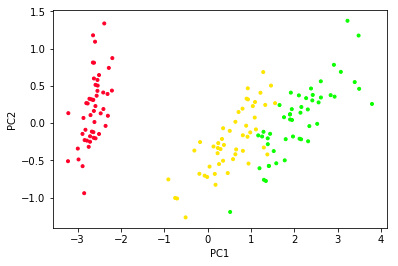

In [4]:
# load (or simulate) data
simulate = False
if not simulate:
    # load iris data
    dataset_name = 'iris'
    features, iris_species = utils_lib.load_data()
    dim = features.shape[1]
    
    # run PCA
    pca_fit = PCA()
    pca_fit.fit(features)
    pc_features = pca_fit.transform(features)
    
    # plot
    fig1 = plt.figure(1)
    fig = fig1.add_subplot(111)
    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
    fig.set_xlabel('PC1')
    fig.set_ylabel('PC2')
    
    
else:
    # Simulate data
    dataset_name = 'simulation'

    n_obs = 1000
    dim = 2
    true_k = 3
    features, true_z, true_components, true_centroids, true_covs, true_probs = \
        simulation_lib.simulate_data(n_obs, dim, true_k, separation=0.4)

    for k in range(true_k):
        plt.plot(features[true_components == k, 0], features[true_components == k, 1], '.')

# Set up the model

In [5]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(3.5)

prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [6]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(
    features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

In [ ]:
# run k-means init
n_kmeans_init = 50
kmeans_init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)

In [ ]:
t0 = time.time()
best_param, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    model.optimize_full(kmeans_init_global_free_param)
t_newton = time.time() - t0

assert converged
print('Done. Converged: ', converged)

Iter: 0	 RMSE: 5.561691210660702	 Objective: 10870.81219254104
Iter: 1	 RMSE: 5.664779512805261	 Objective: 7607.719621514973
Iter: 2	 RMSE: 6.1333257388244	 Objective: 6689.969899221827
Iter: 3	 RMSE: 6.747556339321823	 Objective: 6203.162014279645
Iter: 4	 RMSE: 7.795139236304652	 Objective: 6244.034984368744
Iter: 5	 RMSE: 6.6541732319044975	 Objective: 6060.777732788678
Iter: 6	 RMSE: 7.276798524706333	 Objective: 5917.057572847543
Iter: 7	 RMSE: 7.160866572719088	 Objective: 5698.453128838502
Iter: 8	 RMSE: 7.956405868006484	 Objective: 5501.692487023821
Iter: 9	 RMSE: 10.827861063018572	 Objective: 5471.67230568681
Iter: 10	 RMSE: 11.23410211115474	 Objective: 5416.627884205195
Iter: 11	 RMSE: 11.737767955322337	 Objective: 5316.209654958555
Iter: 12	 RMSE: 12.298196032470564	 Objective: 5143.532886315056
Iter: 13	 RMSE: 13.150777382472015	 Objective: 5059.921882869591
Iter: 14	 RMSE: 12.938938469454174	 Objective: 4923.06068935858
Iter: 15	 RMSE: 13.040209361224974	 Objective: 4

In [ ]:
kl_hessian = model.objective.fun_free_hessian(best_param)

In [ ]:
# look at results
bnp_clusters = np.argmax(model.e_z, axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

In [ ]:
# we plot in PCA space
bnp_centroids_pc, bnp_cluster_covs_pc = \
    utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

In [ ]:
# plot results

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
# colors1_[0] = colors1[2]
# colors1_[1] = colors1[0]
# colors1_[2] = colors1[1]

utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

In [13]:
# save model

fit_dict = gmm_utils.get_checkpoint_dictionary(model, kl_hessian, seed=453453)
base_alpha = model.prior_params['alpha'].get()
filename = 'bnp_full_data_fit_alpha{}_{}.json'.format(base_alpha, dataset_name)
json_output_file = os.path.join(
    './iris_fits_for_nips/',
    filename)
print('saving fit dict to ', json_output_file)
with open(json_output_file, 'w') as outfile:
    json.dump(fit_dict, outfile)


saving fit dict to  ./iris_fits_for_nips/bnp_full_data_fit_alpha3.5_iris.json


# Fit multiple models and save them: 

In [14]:
# we use the original model as an initialization and refit for a range of alphas

In [15]:
alpha_vec = np.arange(start=1.0, stop=16, step=0.5)
# alpha_vec = np.array([1.0])
print(alpha_vec)

[ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5
  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5
 15.  15.5]


In [16]:

for i in range(len(alpha_vec)): 
    print('\n\nRunning for alpha={}'.format(alpha_vec[i]))
       
    # define prior
    prior_params = gmm_utils.get_default_prior_params(dim)
    prior_params['alpha'].set(alpha_vec[i])

    prior_params['prior_gamma_df'].set(8)
    prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

    # define model 
    k_approx = 12
    gh_deg = 8
    model_refit = gmm_utils.DPGaussianMixture(
        features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

    # initialize from the original model 
    init_global_free_param = deepcopy(best_param)
    
    # ...or from kmeans (this gives really erratic results)
    #init_global_free_param = deepcopy(kmeans_init_global_free_param)
    
    # fit model
    t0 = time.time()
    best_param_refit, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        model_refit.optimize_full(init_global_free_param)
    t_newton = time.time() - t0

    assert converged
    print('Done. Converged: ', converged)

    # get KL
    kl_hessian = model_refit.objective.fun_free_hessian(best_param_refit)

    # save model
    fit_dict = gmm_utils.get_checkpoint_dictionary(model_refit, kl_hessian, seed=453453)
    alpha = model_refit.prior_params['alpha'].get()
    filename = 'bnp_full_data_fit_alpha{}_{}.json'.format(alpha, dataset_name)
    json_output_file = os.path.join(
        './iris_fits_for_nips/',
        filename)
    print('saving fit dict to ', json_output_file)
    with open(json_output_file, 'w') as outfile:
        json.dump(fit_dict, outfile)




Running for alpha=1.0
Iter: 0	 RMSE: 11.213295585134356	 Objective: -307.8868323266869
Iter: 1	 RMSE: 11.15574029774783	 Objective: -295.93044119531083
Iter: 2	 RMSE: 11.210665374628304	 Objective: -307.9143066458344
Iter: 3	 RMSE: 11.174997540672809	 Objective: -307.00054601399097
Iter: 4	 RMSE: 11.209569897278508	 Objective: -307.9150931783704
Iter: 5	 RMSE: 11.208744755079595	 Objective: -307.91612271404654
Iter: 6	 RMSE: 11.208265374856172	 Objective: -307.91766574768644
Iter: 7	 RMSE: 11.207792738399736	 Objective: -307.9200770816871
Iter: 8	 RMSE: 11.207571359543751	 Objective: -307.92298833613137
Iter: 9	 RMSE: 11.206539420399755	 Objective: -307.894451424861
Iter: 10	 RMSE: 11.207478015806958	 Objective: -307.9232395462409
Iter: 11	 RMSE: 11.207266475445927	 Objective: -307.9236785903302
Iter: 12	 RMSE: 11.206904893152744	 Objective: -307.9240104774655
Iter: 13	 RMSE: 11.206645026905994	 Objective: -307.9243845321876
Iter: 14	 RMSE: 11.20611723553785	 Objective: -307.92484783

In [17]:
print('Done.')

Done.
